In [42]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

## goal --- take our data from the glodap datasets and make KDE plots of it



### problem:

seaborn, which is reasonably well documented is hard to customize/deal with: 
https://stackoverflow.com/questions/33169093/how-to-label-a-seaborn-contour-plot

https://stackoverflow.com/questions/30145957/plotting-2d-kernel-density-estimation-with-python


https://stackoverflow.com/questions/64362044/what-does-levels-mean-in-seaborn-kde-plot

seaborn also tries to keep the actual contoursets away from the user and didn't respond to changing thresholds or changing colormaps. but it seems to do the same thing as the matplotlib version so let's just use tht and assume the math is the same, which is a reasonable assumption

## example showing seaborn vs matplotlib >> matplotlib version

In [43]:
import arrow
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
#plt.style.use('classic')
from matplotlib.patches import Rectangle
import pickle
from cmocean import cm
import warnings
import netCDF4 as nc
import sys
sys.path.append('../pyscripts/bylayer_extract/')
import extract_bylayer_mean_BOXMASK as ebmBOX 
from importlib import reload
from salishsea_tools import viz_tools

import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy
warnings.simplefilter('ignore')

# plt.rcParams.update({'font.size': 13,
#                      'xtick.labelsize' : 13,
#                      'ytick.labelsize' : 13})

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

%matplotlib inline



In [72]:
data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)


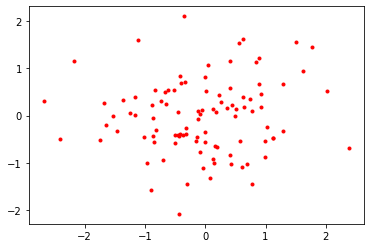

In [73]:
x = data[:, 0]
y = data[:, 1]

plt.plot(x,y,'r.')

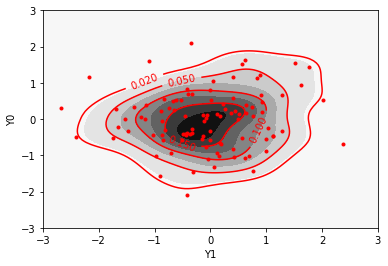

In [74]:

xmin, xmax = -3, 3
ymin, ymax = -3, 3

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Greys')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, levels = [0.02, 0.05, 0.1, 0.15], colors='r', linewidth = 7)

plt.plot(x,y,'r.')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

plt.show()

## seaborn, one level, thres 0.05 and 0.2 > doesn't change

Text(0.5, 1.0, 'thres = 0.05, sns doesnt respond')

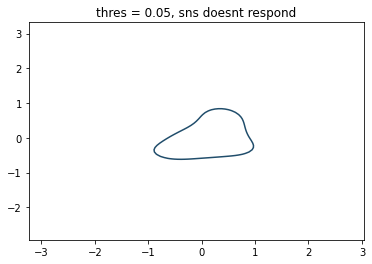

In [47]:
sns.kdeplot(x, y, hue = 'r', levels=1, thres = 0.05)
plt.title('thres = 0.05, sns doesnt respond')

Text(0.5, 1.0, 'thres = 0.2, sns doesnt respond')

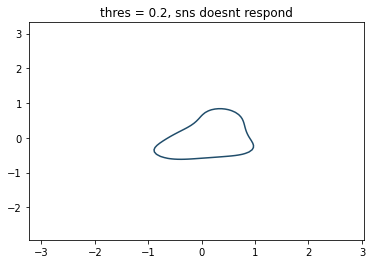

In [51]:
sns.kdeplot(x, y, hue = 'r', levels=1, thres = 0.2)
plt.title('thres = 0.2, sns doesnt respond')

# seaborn 5 levels gives the same plot but isn't pleasantly editable

### from this I'm assuming both do the same thing and it is indeed a density estimate the way seaborn says it is

Text(0.5, 1.0, 'at 5 levels in seaborn we get the same image as above with scipy.stats \n we just cant edit anything, we just make pretty plots because hashtag datascience')

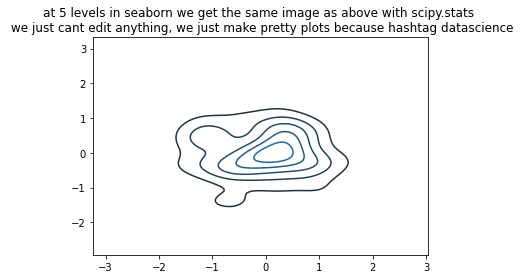

In [52]:
sns.kdeplot(x, y, hue = 'r', levels=5)
plt.title('at 5 levels in seaborn we get the same image as above with scipy.stats \n we just cant edit anything, we just make pretty plots because hashtag datascience' )



## apply what we've just learnt 

In [53]:
### egleston calculations
def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A

# t_omega_DIC, t_beta_DIC, t_gammaDIC, t_OmegaA_A = \
# calculate_Egleston_factors\
# (tTEMP, tSAL, tALK*1e-3, tDIC*1e-3, tPRES, 0.01)



def calculate_Egleston_factors_tPOT(ttemp, tsal, talk, tdic_A, dep, del_dic):

    #return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A
    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tpot', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tpot', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A



In [54]:
#salinity 30, temperature 10 , DIC AND TA vary from 1800 to 2200 
tcmap = cm.thermal

#salinity 0-35
#
S = np.zeros([130,130])
T = np.zeros([130,130])
TA = np.zeros([130,130])
DIC = np.zeros([130,130])

S[:] = 30
T[:] = 10

for i in range(0,130):
    DIC[:,i] = 1400 + 10*i
for i in range(0,130):
    TA[i,:] = 1400 + 10*i


DIC_ar = DIC[0,:]
TA_ar = TA[:,0]  
    
Sr = np.ravel(S)
Tr = np.ravel(T)  
DICr = np.ravel(DIC) * 1e-3
TAr = np.ravel(TA) * 1e-3
del_dic = 10 * 1e-3
zero = DICr *0

response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

#def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
    #return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A
omega_DIC_r= omega_DIC.reshape(130,130)
OmegaA_A_r = OmegaA_A.reshape(130,130)

In [56]:
import pandas as pd

#df = pd.read_csv('../KEY_OTHER_ESTUARIES/data_papers/GLODAPv2.2019_Merged_Master_File.csv')
df = pd.read_csv('../KEY_OTHER_ESTUARIES/data_papers/GLODAPv2.2020_Merged_Master_File.csv')

# data_top = list(df.columns) 
# print(data_top)

In [57]:
#need - bottom depth, pressure, dic, ta, salinity, temp, lat, lon
tALK = np.array(df['talk'][:])
tALK_orig = np.copy(tALK)
tDIC = np.array(df['tco2'][:])
tDIC_orig = np.copy(tDIC)
tSAL = np.array(df['salinity'][:])
tTEMP = np.array(df['temperature'][:])
tPRES = np.array(df['pressure'][:])
tLAT = np.array(df['latitude'][:])
tLON = np.array(df['longitude'][:])
tBOTdepth = np.array(df['bottomdepth'][:])
tYEAR = np.array(df['year'])
tOXY = np.array(df['oxygen'])
#tAOU = np.array(df['aou'][:])

#convert from umol/kg to mmol/m3
import seawater
dens = seawater.dens(tSAL,tTEMP,tPRES)
tDIC=tDIC*dens/1000
tALK=tALK*dens/1000

tALK_DIC = tALK-tDIC
tALK_DIC2 = tALK-(tDIC+50)

tpcfc11 = np.array(df['pcfc11'][:])
tpcfc12 = np.array(df['pcfc12'][:])
tpsf6 = np.array(df['psf6'][:])

In [58]:
#dic, ta, actual reasonable numbers
filt_ALK = ((tALK>-999) & (~np.isnan(tALK)))
filt_DIC = ((tDIC>-999) & (~np.isnan(tDIC)))
filt_SAL = (tSAL >-999) & (~np.isnan(tSAL))
filt_TEMP = (tTEMP >-999) & (~np.isnan(tTEMP))
filt_PRES = (tPRES >-999) & (~np.isnan(tPRES))
filt_EST = (filt_SAL) & (tSAL >= 20 ) & (tPRES < 201)
filt_OXY = (tOXY > -999) & (~np.isnan(tOXY))
#filt_AOU = (tAOU>-999) & (~np.isnan(tAOU))
filt_YEAR = (tYEAR > 2000)
#bottom depth relatively shallow <
filt_DEPTH = (tBOTdepth < 1001) & filt_ALK & filt_DIC & filt_SAL
#year is modern
filt_DEPTH2 = (tBOTdepth < 501) & filt_ALK & filt_DIC & filt_SAL

# filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & filt_TEMP & filt_DIC & filt_ALK

filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK  & filt_YEAR #& filt_AOU



filt_ALK_DIC = (np.abs(tALK_DIC) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)
filt_ALK_DIC2 = (np.abs(tALK_DIC2) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)

filt_cfc = (((tpcfc11>-999) & (~np.isnan(tpcfc11))) | \
               ((tpcfc12>-999) & (~np.isnan(tpcfc12))) | \
               ((tpsf6>-999) & (~np.isnan(tpsf6))) )

filt_comp_cfc = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK  & filt_YEAR & filt_cfc & filt_OXY


# print('total_datapoints with DIC measurements')
# print(np.shape(filt_DIC))
# print('total datapoints with our filt-comp')
# print(np.shape(np.where(filt_comp)))
# print('total datapoints with our filt-comp-cfc')
# print(np.shape(np.where(filt_comp_cfc)))
# print('total datapoints with our filt-comp with abs(TA-DIC)<50')
# print(np.shape(np.where(filt_comp&filt_ALK_DIC)))
# print('total datapoints with our filt-comp with abs(TA-(DIC+50))<50')
# print(np.shape(np.where(filt_comp&filt_ALK_DIC2)))

In [59]:
#dic, ta, actual reasonable numbers
filt_ALK = ((tALK>-999) & (~np.isnan(tALK)))
filt_DIC = ((tDIC>-999) & (~np.isnan(tDIC)))
filt_SAL = (tSAL >-999) & (~np.isnan(tSAL))
filt_TEMP = (tTEMP >-999) & (~np.isnan(tTEMP))
filt_PRES = (tPRES >-999) & (~np.isnan(tPRES))
filt_EST = (filt_SAL) & (tSAL >= 20 ) & (tPRES < 201)
filt_OXY = (tOXY > -999) & (~np.isnan(tOXY))
#filt_AOU = (tAOU>-999) & (~np.isnan(tAOU))
filt_YEAR = (tYEAR > 2000)
#bottom depth relatively shallow <
filt_DEPTH = (tBOTdepth < 1001) & filt_ALK & filt_DIC & filt_SAL
#year is modern
filt_DEPTH2 = (tBOTdepth < 501) & filt_ALK & filt_DIC & filt_SAL

# filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & filt_TEMP & filt_DIC & filt_ALK

filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK  & filt_YEAR #& filt_AOU



filt_ALK_DIC = (np.abs(tALK_DIC) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)
filt_ALK_DIC2 = (np.abs(tALK_DIC2) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)

filt_cfc = (((tpcfc11>-999) & (~np.isnan(tpcfc11))) | \
               ((tpcfc12>-999) & (~np.isnan(tpcfc12))) | \
               ((tpsf6>-999) & (~np.isnan(tpsf6))) )

filt_comp_cfc = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK  & filt_YEAR & filt_cfc & filt_OXY


# print('total_datapoints with DIC measurements')
# print(np.shape(filt_DIC))
# print('total datapoints with our filt-comp')
# print(np.shape(np.where(filt_comp)))
# print('total datapoints with our filt-comp-cfc')
# print(np.shape(np.where(filt_comp_cfc)))
# print('total datapoints with our filt-comp with abs(TA-DIC)<50')
# print(np.shape(np.where(filt_comp&filt_ALK_DIC)))
# print('total datapoints with our filt-comp with abs(TA-(DIC+50))<50')
# print(np.shape(np.where(filt_comp&filt_ALK_DIC2)))

In [60]:
###### manually assign geolocations
tGEO = np.zeros_like(tBOTdepth)

#canadian arctic
westlon = -148; eastlon = -50; southlat = 60; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 1

#euro arctic
westlon = -30; eastlon = 91; southlat = 70; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 2
#atlantic 1
westlon = -50; eastlon = 30; southlat = 0; northlat = 70
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#atlantic 2
westlon = -100; eastlon = -50; southlat = 0; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#siberian arctic
westlon = 91; eastlon = 180; southlat = 68; northlat = 91
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 4
#pacific coast
westlon = -140; eastlon = -100; southlat = 10; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 5
#Russian-Alaskan Interface
westlon = -180; eastlon = -148; southlat = 50; northlat = 90
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 6
#Kamchatka Region
westlon = 120; eastlon = 180; southlat = 48; northlat = 68
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 7
#Japan and China
westlon = 120; eastlon = 180; southlat = 10; northlat = 48
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 8
#SO
westlon = -180; eastlon = 180; southlat = -90; northlat = -60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 9

In [61]:
PLACES_withdat = {
'Canadian Arctic': { 'geodat': 1, 'colour': 'blueviolet', 'name':'Canadian Arctic'},
'European Arctic': { 'geodat': 2, 'colour': 'darkorange', 'name':'European Arctic'},
'N. Atlantic': { 'geodat': 3, 'colour': 'red', 'name':'N. Atlantic'},
'Siberian Arctic': { 'geodat': 4, 'colour': 'dodgerblue', 'name':'Siberian Arctic'},
'Coastal Pacific': { 'geodat': 5, 'colour': 'blue', 'name':'Coastal Pacific'},
'Russian/Alaskan Interface': { 'geodat': 6, 'colour': 'skyblue', 'name':'Russian/Alaskan \n Interface'},
'Kamchatka Region': { 'geodat': 7, 'colour': 'lightsteelblue', 'name':'Kamchatka Region'},
'China/Japan': { 'geodat': 8, 'colour': 'steelblue', 'name':'China/Japan'},
'Southern Ocean': { 'geodat': 9, 'colour': 'green', 'name':'Southern Ocean'},
'Everything Else': { 'geodat': 0, 'colour': 'grey', 'name':'Everything Else'},
}

list_places = ['Everything Else','Canadian Arctic','European Arctic',
'N. Atlantic','Siberian Arctic','Coastal Pacific',
'Russian/Alaskan Interface',
'Kamchatka Region','China/Japan',
'Southern Ocean',]

print(list_places)


['Everything Else', 'Canadian Arctic', 'European Arctic', 'N. Atlantic', 'Siberian Arctic', 'Coastal Pacific', 'Russian/Alaskan Interface', 'Kamchatka Region', 'China/Japan', 'Southern Ocean']


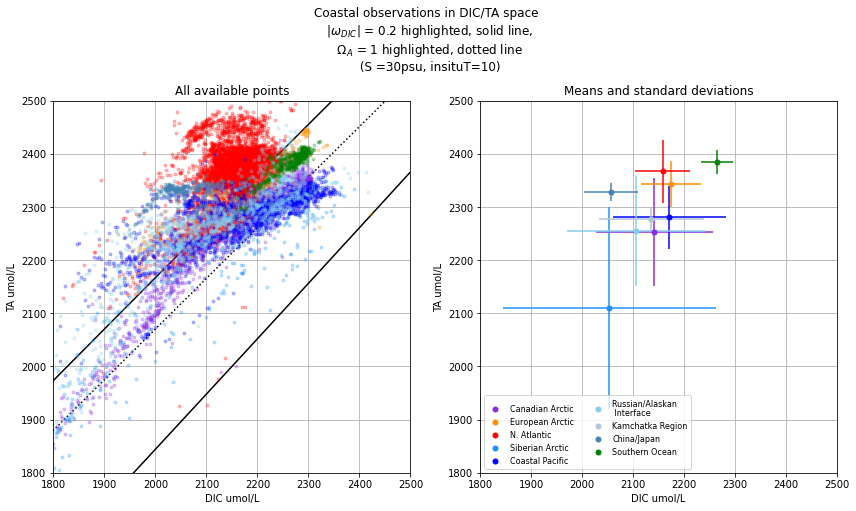

In [63]:
omega_lev = 0.2
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(20*fact,12*fact))
ax = plt.subplot(1,2,1)
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(tDIC[filt_comp & (tGEO == geotag)],\
            tALK[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)

ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], linestyles = 'dotted', colors = 'k' )
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])

ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')    
ax.set_title('All available points')

ax = plt.subplot(1,2,2)
fs = 8
tcol = 'black'
tlw = 4.5
ms = 10

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
            np.nanmean(tALK[filt_comp & (tGEO == geotag)]),\
           color = tcol, marker = '.', markersize = ms, \
            linestyle = '',\
           label = tnam, alpha = 1)
    ax.errorbar(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
                np.nanmean(tALK[filt_comp & (tGEO == geotag)]), \
                xerr = np.nanstd(tDIC[filt_comp & (tGEO == geotag)]),\
                yerr = np.nanstd(tALK[filt_comp & (tGEO == geotag)]),
                fmt="o",
               color = tcol, marker = '.', linestyle = '',\
            alpha = 1)
ax.legend(ncol = 2, loc = 'best', fontsize = 8)
ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')
ax.set_title('Means and standard deviations')
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])
#ax.contour(X, Y, -omega_DIC_r, levels=[omega_lev], colors = 'k')
#ax.contour(X, Y, OmegaAr_vTD, levels=[1], linestyles = 'dotted', colors = 'k' )
plt.suptitle('Coastal observations in DIC/TA space \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line \n (S =30psu, insituT=10)')


plt.tight_layout()

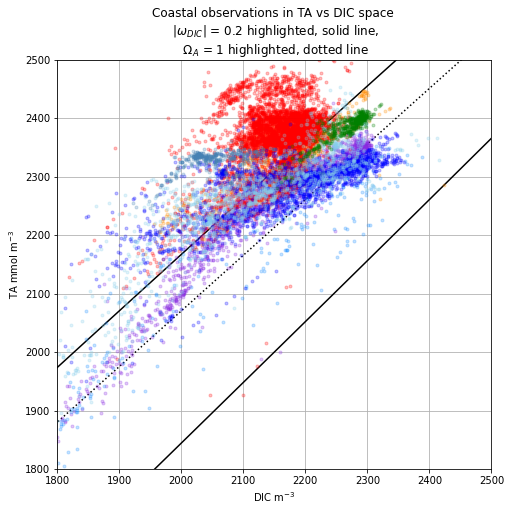

In [64]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(12*fact,12*fact))
ax = plt.subplot(1,1,1)
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(tDIC[filt_comp & (tGEO == geotag)],\
            tALK[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)

ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], linestyles = 'dotted', colors = 'k' )
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])

ax.set_ylabel('TA mmol m$^{-3}$')
ax.set_xlabel('DIC m$^{-3}$')    
ax.set_title('Coastal observations in TA vs DIC space \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line')




plt.tight_layout()

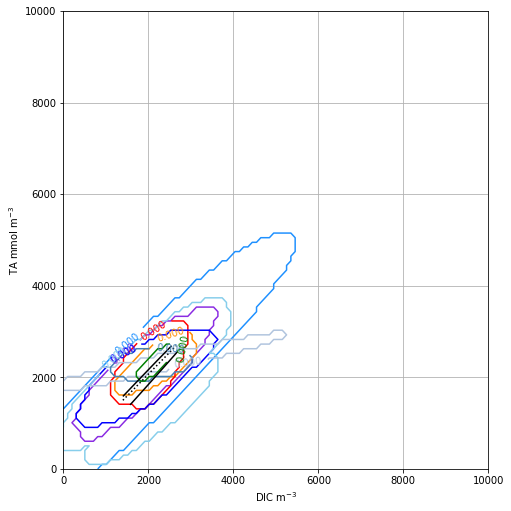

In [97]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(12*fact,12*fact))
ax = plt.subplot(1,1,1)
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,len(list_places)):


    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
#     ax.plot(tDIC[filt_comp & (tGEO == geotag)],\
#             tALK[filt_comp & (tGEO == geotag)],\
#            color = tcol, marker = '.', linestyle = '',\
#            label = tnam, alpha = talph)

    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    xmin, xmax = 0, 10000
    ymin, ymax = 0, 10000

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)


    # Contourf plot
#     cfset = ax.contourf(xx, yy, f, cmap='Greys')
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    cset = ax.contour(xx, yy, f, levels = [0.05,0.1,0.15], colors=tcol)
    ax.clabel(cset, inline=1, fontsize=10)


    
ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], linestyles = 'dotted', colors = 'k' )
ax.grid()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_ylabel('TA mmol m$^{-3}$')
ax.set_xlabel('DIC m$^{-3}$')    
#ax.set_title('Coastal observations in TA vs DIC space \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line')




plt.tight_layout()

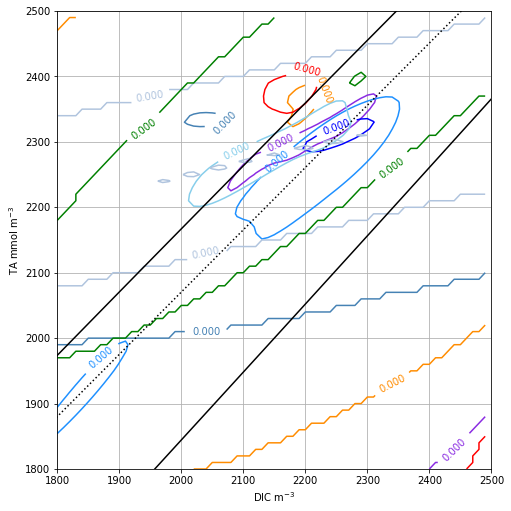

In [93]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(12*fact,12*fact))
ax = plt.subplot(1,1,1)
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,len(list_places)):


    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
#     ax.plot(tDIC[filt_comp & (tGEO == geotag)],\
#             tALK[filt_comp & (tGEO == geotag)],\
#            color = tcol, marker = '.', linestyle = '',\
#            label = tnam, alpha = talph)

    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    xmin, xmax = 1800, 2500
    ymin, ymax = 1800, 2500

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:10, ymin:ymax:10]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)


    # Contourf plot
#     cfset = ax.contourf(xx, yy, f, cmap='Greys')
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    cset = ax.contour(xx, yy, f, levels = 1, colors=tcol)
    ax.clabel(cset, inline=1, fontsize=10)


    
ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], linestyles = 'dotted', colors = 'k' )
ax.grid()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_ylabel('TA mmol m$^{-3}$')
ax.set_xlabel('DIC m$^{-3}$')    
#ax.set_title('Coastal observations in TA vs DIC space \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line')




plt.tight_layout()

In [88]:
print(np.shape(values))

(2, 471)


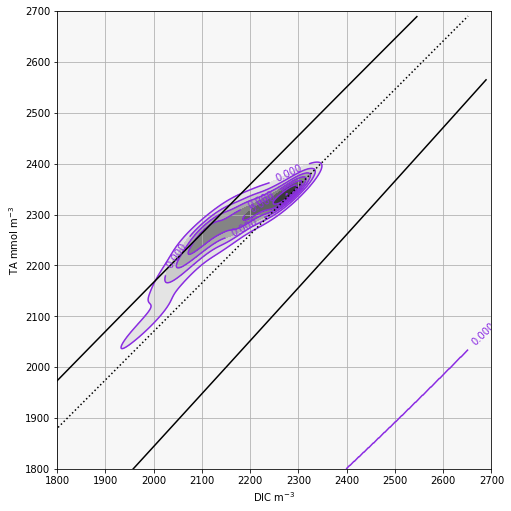

In [105]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(12*fact,12*fact))
ax = plt.subplot(1,1,1)
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,2):#len(list_places)):


    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
#     ax.plot(tDIC[filt_comp & (tGEO == geotag)],\
#             tALK[filt_comp & (tGEO == geotag)],\
#            color = tcol, marker = '.', linestyle = '',\
#            label = tnam, alpha = talph)

    
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
    
    xmin, xmax = 1800, 2700
    ymin, ymax = 1800, 2700

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:1, ymin:ymax:1]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)


    # Contourf plot
    cfset = ax.contourf(xx, yy, f, cmap='Greys')
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    cset = ax.contour(xx, yy, f, colors=tcol)
    ax.clabel(cset, inline=1, fontsize=10)


    
ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], linestyles = 'dotted', colors = 'k' )
ax.grid()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_ylabel('TA mmol m$^{-3}$')
ax.set_xlabel('DIC m$^{-3}$')    
#ax.set_title('Coastal observations in TA vs DIC space \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line')




plt.tight_layout()

In [106]:
np.nanmean(f)

1.2258533047146281e-06